In [51]:
import numpy as np
import cv2 as cv

import sys

class App():
    BLUE = [255,0,0]        # rectangle color
    RED = [0,0,255]         # PR BG
    GREEN = [0,255,0]       # PR FG
    BLACK = [0,0,0]         # sure BG
    WHITE = [255,255,255]   # sure FG

    DRAW_BG = {'color' : BLACK, 'val' : 0}
    DRAW_FG = {'color' : WHITE, 'val' : 1}
    DRAW_PR_FG = {'color' : GREEN, 'val' : 3}
    DRAW_PR_BG = {'color' : RED, 'val' : 2}

    # setting up flags
    rect = (0,0,1,1)
    drawing = False         # flag for drawing curves
    rectangle = False       # flag for drawing rect
    rect_over = False       # flag to check if rect drawn
    rect_or_mask = 100      # flag for selecting rect or mask mode
    value = DRAW_FG         # drawing initialized to FG
    thickness = 3           # brush thickness

    def onmouse(self, event, x, y, flags, param):
        
        # Draw Rectangle
        if event == cv.EVENT_RBUTTONDOWN:
            self.rectangle = True
            self.ix, self.iy = x,y

        elif event == cv.EVENT_MOUSEMOVE:
            if self.rectangle == True:
                self.img = self.img2.copy()
                cv.rectangle(self.img, (self.ix, self.iy), (x, y), self.BLUE, 2)
                self.rect = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.rect_or_mask = 0

        elif event == cv.EVENT_RBUTTONUP:
            self.rectangle = False
            self.rect_over = True
            cv.rectangle(self.img, (self.ix, self.iy), (x, y), self.BLUE, 2)
            self.rect = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.rect_or_mask = 0
            print(" Now press the key 'n' a few times until no further change \n")

        # draw touchup curves

        if event == cv.EVENT_LBUTTONDOWN:
            if self.rect_over == False:
                print("first draw rectangle \n")
            else:
                self.drawing = True
                cv.circle(self.img, (x,y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x,y), self.thickness, self.value['val'], -1)

        elif event == cv.EVENT_MOUSEMOVE:
            if self.drawing == True:
                cv.circle(self.img, (x, y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x, y), self.thickness, self.value['val'], -1)

        elif event == cv.EVENT_LBUTTONUP:
            if self.drawing == True:
                self.drawing = False
                cv.circle(self.img, (x, y), self.thickness, self.value['color'], -1)
                cv.circle(self.mask, (x, y), self.thickness, self.value['val'], -1)

    def run(self, filename):
        self.img = cv.imread(cv.samples.findFile(filename))
        self.img2 = self.img.copy()                               # a copy of original image
        self.mask = np.zeros(self.img.shape[:2], dtype = np.uint8) # mask initialized to PR_BG
        self.output = np.zeros(self.img.shape, np.uint8)           # output image to be shown

        # input and output windows
        cv.namedWindow('output',cv.WINDOW_GUI_NORMAL)
        cv.namedWindow('input', cv.WINDOW_GUI_NORMAL)
        cv.setMouseCallback('input', self.onmouse)
        cv.moveWindow('input', self.img.shape[1]+10,90)

        print(" Instructions: \n")
        print(" Draw a rectangle around the object using right mouse button \n")

        while(1):

            cv.imshow('output', self.output)
            cv.imshow('input', self.img)
            k = cv.waitKey(1)

            # key bindings
            if k == 27:         # esc to exit
                break
            elif k == ord('0'): # BG drawing
                print(" mark background regions with left mouse button \n")
                self.value = self.DRAW_BG
            elif k == ord('1'): # FG drawing
                print(" mark foreground regions with left mouse button \n")
                self.value = self.DRAW_FG
            elif k == ord('2'): # PR_BG drawing
                self.value = self.DRAW_PR_BG
            elif k == ord('3'): # PR_FG drawing
                self.value = self.DRAW_PR_FG
            elif k == ord('s'): # save image
                bar = np.zeros((self.img.shape[0], 5, 3), np.uint8)
                res = np.hstack((self.img2, bar, self.img, bar, self.output))
                cv.imwrite('grabcut_output.png', res)
                print(" Result saved as image \n")
                
                result = {
                    'rect': self.rect,
                    'markers': self.mask
                }
                
                np.save(filename, result)
                print(self.rect)
                
            elif k == ord('r'): # reset everything
                print("resetting \n")
                self.rect = (0,0,1,1)
                self.drawing = False
                self.rectangle = False
                self.rect_or_mask = 100
                self.rect_over = False
                self.value = self.DRAW_FG
                self.img = self.img2.copy()
                self.mask = np.zeros(self.img.shape[:2], dtype = np.uint8) # mask initialized to PR_BG
                self.output = np.zeros(self.img.shape, np.uint8)           # output image to be shown
            elif k == ord('n'): # segment the image
                print(""" For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' \n""")
                try:
                    if (self.rect_or_mask == 0):         # grabcut with rect
                        bgdmodel = np.zeros((1, 65), np.float64)
                        fgdmodel = np.zeros((1, 65), np.float64)
                        cv.grabCut(self.img2, self.mask, self.rect, bgdmodel, fgdmodel, 1, cv.GC_INIT_WITH_RECT)
                        self.rect_or_mask = 1
                    elif self.rect_or_mask == 1:         # grabcut with mask
                        bgdmodel = np.zeros((1, 65), np.float64)
                        fgdmodel = np.zeros((1, 65), np.float64)
                        cv.grabCut(self.img2, self.mask, self.rect, bgdmodel, fgdmodel, 1, cv.GC_INIT_WITH_MASK)
                except:
                    import traceback
                    traceback.print_exc()

            mask2 = np.where((self.mask==1) + (self.mask==3), 255, 0).astype('uint8')
            self.output = cv.bitwise_and(self.img2, self.img2, mask=mask2)

        print('Done')


filename = 'obj6.jpg'

App().run(filename)
cv.destroyAllWindows()

 Instructions: 

 Draw a rectangle around the object using right mouse button 

 Now press the key 'n' a few times until no further change 

 For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' 

 mark background regions with left mouse button 

 For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' 

 mark foreground regions with left mouse button 

 For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' 

 For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' 

 For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' 

 For finer touchups, mark foreground and background after pressing keys 0-3
                and again press 'n' 

 mark background regions with left mouse button 

 For finer touchups, mark

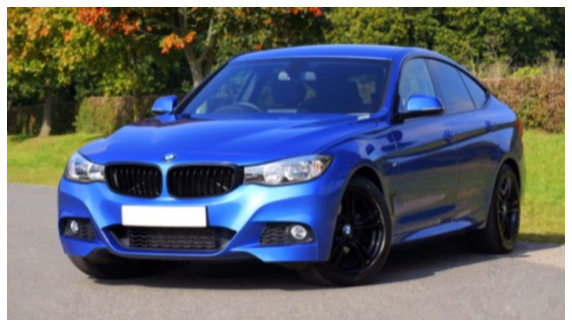

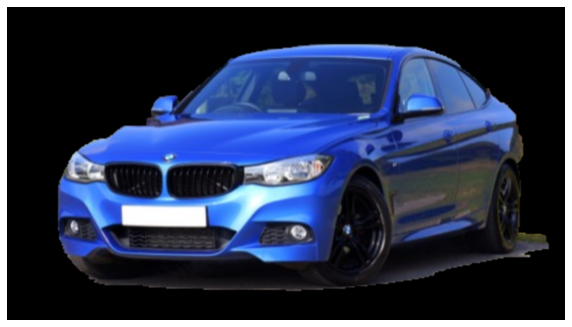

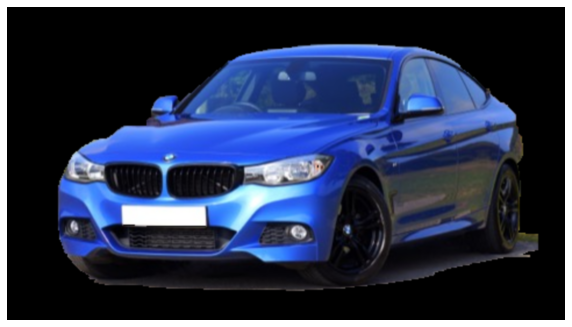

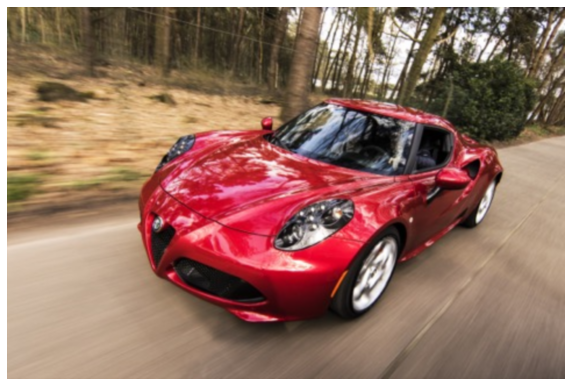

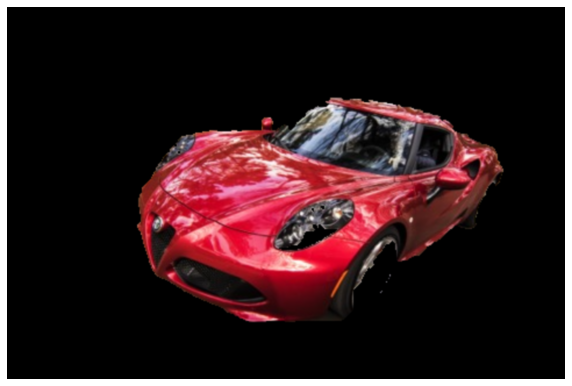

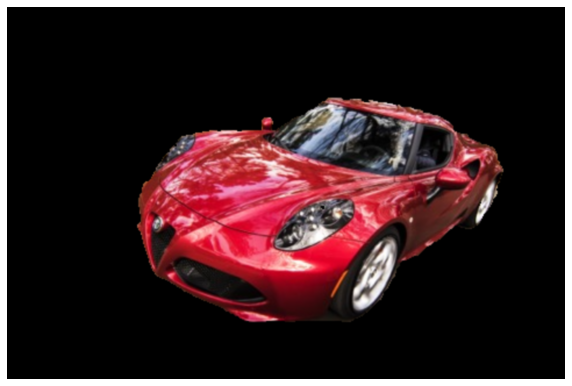

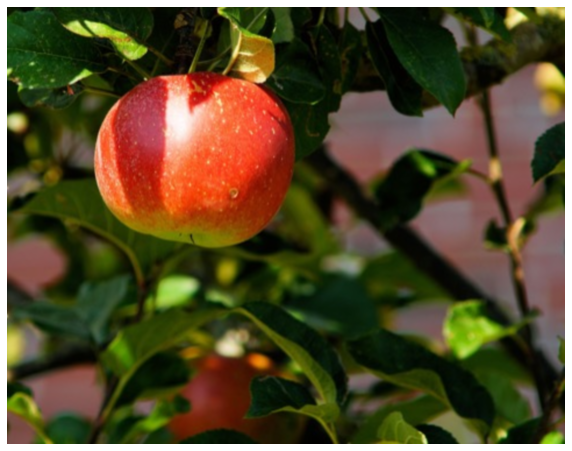

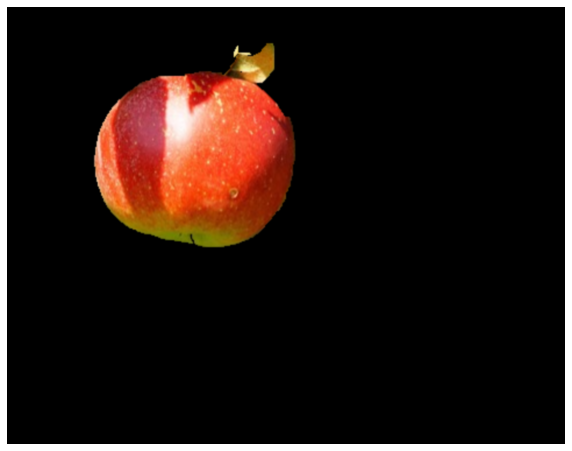

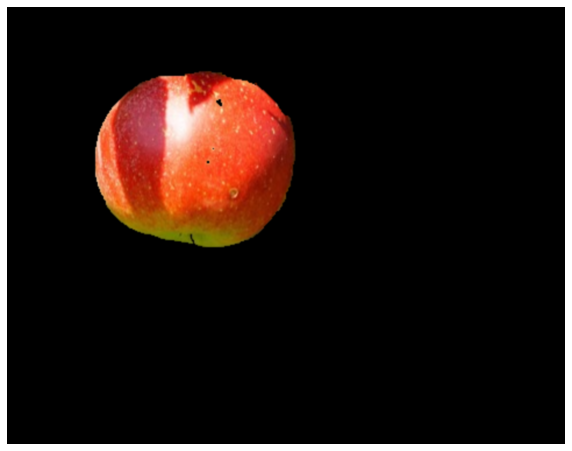

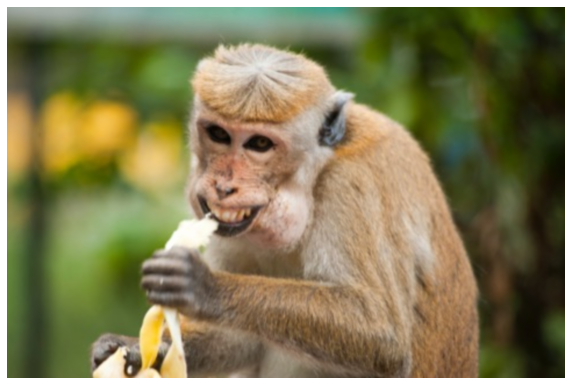

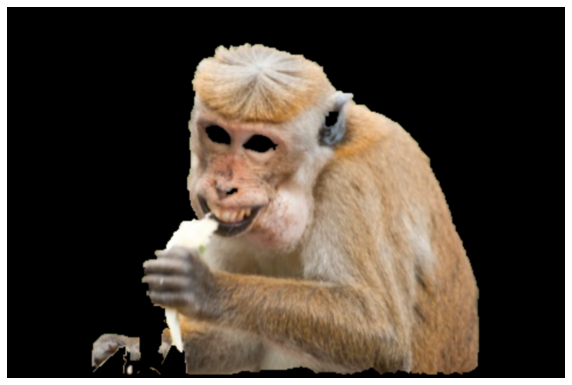

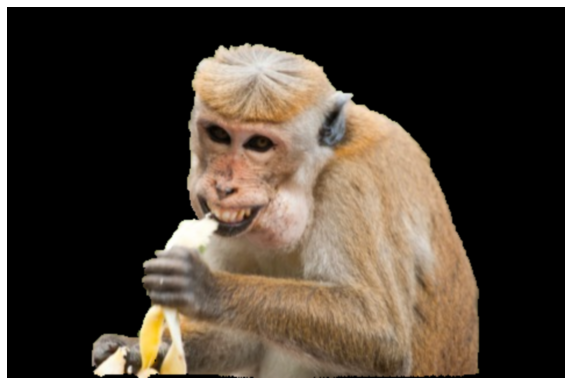

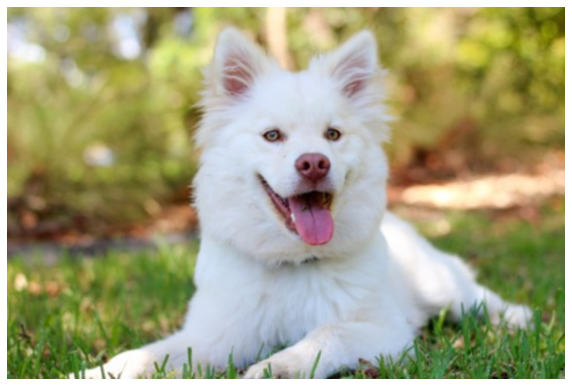

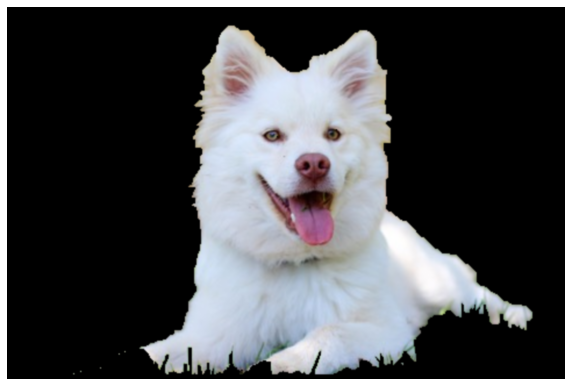

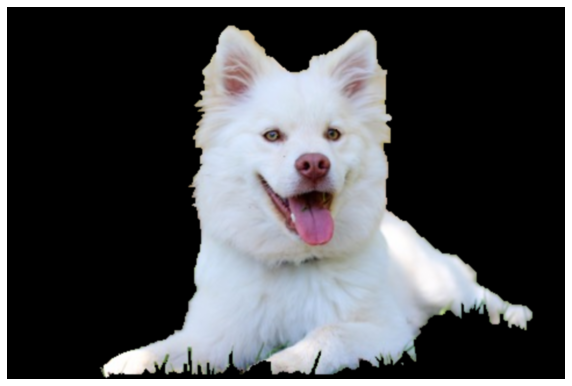

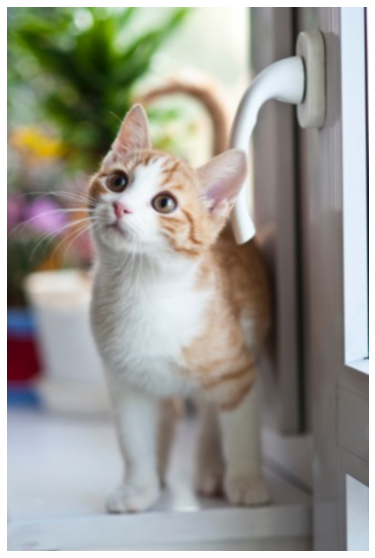

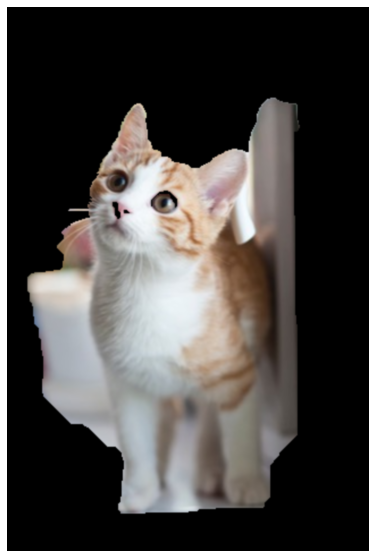

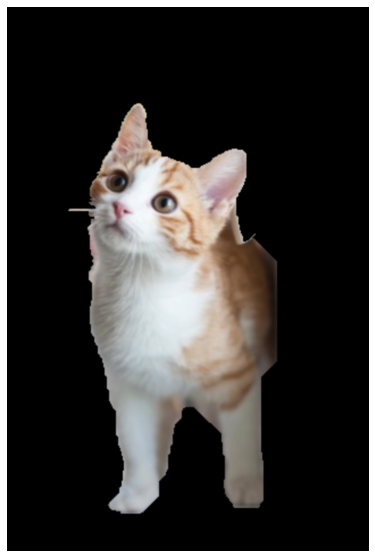

In [55]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

def cv2_imshow(img):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.axis("off")
    plt.show()
    
for filename in ['obj1.jpg','obj2.jpg','obj3.jpg','obj4.jpg','obj5.jpg','obj6.jpg']:
    img = cv2.imread(filename)
    cv2_imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    mask_obj = np.load(filename + '.npy',allow_pickle=True)

    rect = mask_obj.item().get('rect')
    markers = mask_obj.item().get('markers')

    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    # rec
    cv2.grabCut(np.copy(img),mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img1 = img*mask2[:,:,np.newaxis]
    cv2_imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))

    # markers
    mask, bgdModel, fgdModel = cv2.grabCut(np.copy(img),markers,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img1 = img*mask[:,:,np.newaxis]
    cv2_imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))